# Predict Bike Rentals using Decision Tree and Random Forest

This project will analyze a dataset containing records of bike rentals in Washington D.C., and attempt to predict the number of bikes rented on any given day. A few models will be built and compared for the predictions. Ultimately, the model could be used to predict future bike rentals, given parameters such as weather, date, etc.

In [1]:
import pandas as pd

# read the data into a dataframe
bike_rentals = pd.read_csv('bike_rental_hour.csv')

# verify the data
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


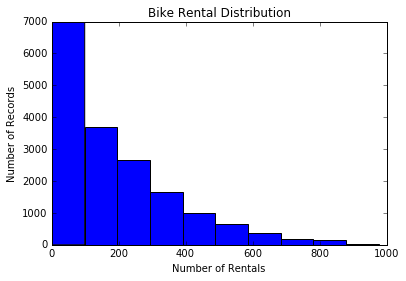

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

# visualize the distribution of historical bike rentals
plt.hist(bike_rentals['cnt'])
plt.title('Bike Rental Distribution')
plt.xlabel('Number of Rentals')
plt.ylabel('Number of Records')
plt.show()

In [9]:
# determine which columns from the data set are best correlated with 'cnt'
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

### Assign time of day labels based on hour

The code below will label each record with what part of the day the rental count was given, based on the hour column.

In [19]:
# define function to label the time of day
def assign_label(hour):
    if ((hour >= 6) & (hour < 12)):
        return 1
    elif ((hour >= 12) & (hour < 18)):
        return 2
    elif ((hour >= 18) & (hour <= 24)):
        return 3
    elif ((hour >= 0) & (hour < 6)):
        return 4
    
# apply the function to the each row in the dataframe
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

# verify the new column values
bike_rentals[['hr', 'time_label']].head(25)

,hr,time_label
0,0,4
1,1,4
2,2,4
3,3,4
4,4,4
5,5,4
6,6,1
7,7,1
8,8,1
9,9,1


### Define error metrics for machine learning

Since the machine learning algorithms applied for this project will be regressors (predicting a continuous value), the error metric that will be used is the Mean Squared Error, which looks at the square of the distance between the initial and predicted values.

Reference: https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

In [22]:
import numpy as np

# split the data into a training set and a test set
rentals_length = len(bike_rentals)

# shuffle data
random_indexes = np.random.permutation(bike_rentals.index)
bike_rentals = bike_rentals.reindex(random_indexes)

# assign 80% of records to the training set, and remaining 20% to the test set
eighty_pct = round(rentals_length * 0.8)
train = bike_rentals[:eighty_pct]
test = bike_rentals[eighty_pct:]

# verify the number of records in the training and test data sets
print(len(bike_rentals))
print(len(train))
print(len(test))

17379
13903
3476


In [27]:
# verify that no records from the training set are found in the test set
np.unique(train.index.isin(test.index))

array([False])

### Define features for prediction and start with Linear Regression

The code below will select feature columns to use within the Linear Regression and Random Forest models, excluding the 'cnt', 'casual', and 'registered' columns, since those columns are the target column (cnt), and columns added to get the target column. Other columns that aren't highly correlated with 'cnt' will be excluded as well.

In [36]:
# select features
features = []

for col in bike_rentals.columns:
    features.append(col)

remove_cols = ['cnt', 'casual', 'registered', 'dteday']

for c in remove_cols:
    features.remove(c)

# verify final features
print(features)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']


In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# fit a linear regression model using the training set
lr = LinearRegression()
lr.fit(train[features], train['cnt'])

# make predictions using the test set
lr_predictions = lr.predict(test[features])

# calculate the mean squared error of the model
lr_mse = mean_squared_error(test['cnt'], lr_predictions)
print('Mean Squared Error:', lr_mse)

Mean Squared Error: 17375.631838335004


### Linear Regression analysis

The Mean Squared Error of 17,375.63 is high, which may be due to the fact that some features that don't have a linear relationship with the target column are being used.

### Decision Tree and Random Forest

The code below will attempt to predict the rental count using the same features as the linear regression model. The Mean Squared Error of each will be compared to the other models.

In [74]:
from sklearn.tree import DecisionTreeRegressor

# fit a decision tree
dt = DecisionTreeRegressor(min_samples_leaf=4)
dt.fit(train[features], train['cnt'])

# make predictions
dt_predictions = dt.predict(test[features])

# calculate Mean Squared Error
dt_mse = mean_squared_error(test['cnt'], dt_predictions)
print('Decision Tree Mean Squared Error', dt_mse)

Decision Tree Mean Squared Error 2719.0007870408426


### Decision Tree analysis

The Mean Squared Error of the Decision Tree model is 2,719, which is much lower than the Linear Regression model. The Decision Tree is a much more accurate model for this project, compared to the Linear Regression model.

In [84]:
from sklearn.ensemble import RandomForestRegressor

# build a Random Forest model with 25 trees
rf = RandomForestRegressor(n_estimators=25)
rf.fit(train[features], train['cnt'])

# make predictions
rf_predictions = rf.predict(test[features])

# calculate Mean Squared Error
rf_mse = mean_squared_error(test['cnt'], rf_predictions)
print('Random Forest Mean Squared Error:', rf_mse)

Random Forest Mean Squared Error: 1724.9157054085158


### Random Forest analysis

The Mean Squared Error for the Random Forest model is 1,724.92, which is even lower than the single Decision Tree. Since a Random Forest is multiple decision trees making predictions, Random Forests are less prone to overfitting, which may be a reason the MSE is lower, as compared to a single Decision Tree.